In [2]:
import os
import sys

import numpy as np
import matplotlib.pyplot as plt
import gymnasium as gym
from stable_baselines3 import PPO
from stable_baselines3.common.env_checker import check_env
from stable_baselines3.common.env_util import make_vec_env
from stable_baselines3.common.callbacks import EvalCallback
from stable_baselines3.common.vec_env import SubprocVecEnv
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.callbacks import CheckpointCallback
from gymnasium import spaces
import torch

## Load Traffic Environment

In [4]:
# Add the `src` folder to the Python path
sys.path.append(os.path.join(os.path.abspath('..'), 'src'))
import environment_gym as env_gym

## Create Evaluation and Test Function

In [6]:
def evaluate_model(log_path):
    """
    Reads the mean reward from the evaluation log and plots it to monitor convergence.

    Args:
    - log_path (str): Path to the directory containing the log file.
    """
    # Find the monitor CSV file generated by EvalCallback
    monitor_file = os.path.join(log_path, 'evaluations.npz')

    if not os.path.isfile(monitor_file):
        print("Error: Log file not found.")
        return

    # Load evaluation results
    results = np.load(monitor_file)
    mean_rewards = results['results'].mean(axis=1)  # Mean reward per evaluation

    # Plot the mean reward to observe convergence
    plt.plot(mean_rewards)
    plt.xlabel('Evaluation Step (x1000 timesteps)')
    plt.ylabel('Mean Reward')
    plt.title('Model Convergence')
    plt.show()

In [7]:
def test_model(model_path, env, num_episodes):
    """
    Evaluates the model over a specified number of episodes, records rewards for each episode,
    and plots the rewards.

    Args:
    - model_path (str): Path to the saved model.
    - env (gym.Env): The environment to evaluate the model on.
    - num_episodes (int): Total number of episodes to run the evaluation.

    Returns:
    - episode_rewards (list): List of total rewards for each episode.
    """
    # Load the model
    model = PPO.load(model_path)

    # Initialize a list to store rewards for each episode
    episode_rewards = []

    # Run the model for the specified number of episodes
    for episode in range(num_episodes):
        obs, info = env.reset()
        episode_reward = 0  

        while True:  # Run until the episode ends
            action, _states = model.predict(obs, deterministic=True)
            action = action.item()
            obs, reward, terminated, truncated, info = env.step(action)
            episode_reward += reward  # Accumulate reward

            # Check if the episode is done
            if terminated or truncated:
                episode_reward = round(episode_reward)
                episode_rewards.append(episode_reward)  # Record total reward for the episode
                break  # Exit the loop to start a new episode

    # Calculate average reward
    reward_ave = round(sum(episode_rewards) / num_episodes)
    print(f"Average reward of {num_episodes} episodes is {reward_ave}.")
    
    # Plot the episode rewards
    plt.plot(episode_rewards)
    plt.xlabel('Episode')
    plt.ylabel('Total Reward')
    plt.title('Rewards per Episode')
    plt.show()

    return episode_rewards

## Baseline PPO Agent

In [9]:
# Initialize and vectorize the environment for parallel processing
env = env_gym.TrafficEnvironment()
check_env(env, warn=True)
env.reset()

eval_env = Monitor(env_gym.TrafficEnvironment())
check_env(eval_env, warn=True)
eval_env.reset()

# Define the PPO model with MlpPolicy (a policy network that works well with continuous environments)
model = PPO("MlpPolicy", env, verbose=1, device="cpu")

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./logs/ppo_baseline_model',
    log_path='./logs/baseline_results',
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

# Train the PPO model
total_timesteps = 50000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=-13615.00 +/- 15780.81
Episode length: 1174.40 +/- 1051.99
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.17e+03  |
|    mean_reward     | -1.36e+04 |
| time/              |           |
|    total_timesteps | 1000      |
----------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-7023.00 +/- 13006.57
Episode length: 735.00 +/- 867.04
----------------------------------
| eval/              |           |
|    mean_ep_length  | 735       |
|    mean_reward     | -7.02e+03 |
| time/              |           |
|    total_timesteps | 2000      |
----------------------------------
New best mean reward!
----------------------------------
| rollout/           |           |
|    ep_len_mean     | 468       |
|    ep_rew_mean     | -2.23e+03 |
| time/              |           |
| 

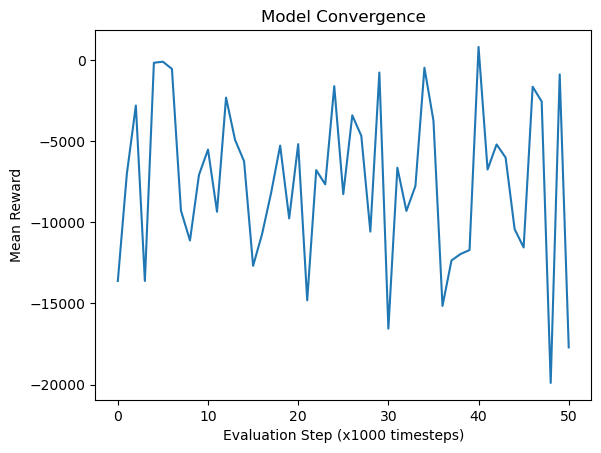

In [10]:
evaluate_model(log_path='./logs/baseline_results')

Average reward of 100 episodes is -6517.


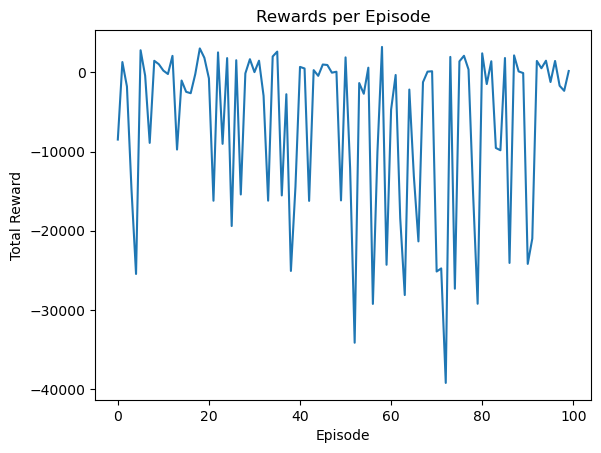

[-8490,
 1290,
 -1790,
 -14770,
 -25450,
 2780,
 -430,
 -8910,
 1450,
 1020,
 210,
 -220,
 2070,
 -9750,
 -1040,
 -2470,
 -2640,
 -240,
 3010,
 1830,
 -770,
 -16210,
 2510,
 -9030,
 1790,
 -19400,
 1520,
 -15420,
 -140,
 1650,
 20,
 1460,
 -2970,
 -16200,
 1990,
 2610,
 -15540,
 -2770,
 -25070,
 -14450,
 680,
 480,
 -16230,
 270,
 -450,
 980,
 920,
 -50,
 70,
 -16170,
 1880,
 -12080,
 -34130,
 -1360,
 -2710,
 580,
 -29230,
 -10060,
 3200,
 -24290,
 -4710,
 -340,
 -18390,
 -28110,
 -2180,
 -13150,
 -21340,
 -1250,
 80,
 130,
 -25140,
 -24750,
 -39200,
 1940,
 -27310,
 1380,
 2080,
 350,
 -15290,
 -29210,
 2390,
 -1490,
 1390,
 -9550,
 -9840,
 1800,
 -24060,
 2130,
 110,
 -100,
 -24180,
 -20980,
 1430,
 510,
 1460,
 -1230,
 1430,
 -1700,
 -2340,
 160]

In [11]:
# Model testing
model_path = './logs/ppo_baseline_model/best_model.zip'
env_test = env_gym.TrafficEnvironment()
num_episodes = 100
test_model(model_path=model_path, env=env, num_episodes=num_episodes)

## Finetune PPO Agent

In [13]:
# Initialize and vectorize the environment
env = env_gym.TrafficEnvironment()
env.reset()
eval_env = Monitor(env_gym.TrafficEnvironment())
eval_env.reset()

# Set up evaluation callback
eval_callback = EvalCallback(
    eval_env,
    best_model_save_path='./logs/ppo_finetune_model',
    log_path='./logs/finetune_results',
    eval_freq=1000,  # Evaluate the model every 1000 steps
    deterministic=True,
    render=False
)

# Define the PPO model with MlpPolicy
model = PPO(
    "MlpPolicy", 
    env, 
    verbose=1,
    device = "cpu",
    learning_rate=2e-4,         
    n_steps=4096,               
    batch_size=128,              
    gae_lambda=0.95,            
    gamma=0.99,                 
    clip_range=0.1,
    # clip_range_vf=0.1,
    n_epochs=20,
    # ent_coef=0.005,
    # target_kl=0.01
)

# Train the PPO model
total_timesteps = 50000
model.learn(total_timesteps=total_timesteps, callback=eval_callback)

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Eval num_timesteps=1000, episode_reward=-18968.00 +/- 13870.35
Episode length: 2289.00 +/- 1381.58
---------------------------------
| eval/              |          |
|    mean_ep_length  | 2.29e+03 |
|    mean_reward     | -1.9e+04 |
| time/              |          |
|    total_timesteps | 1000     |
---------------------------------
New best mean reward!
Eval num_timesteps=2000, episode_reward=-15640.00 +/- 15007.47
Episode length: 1960.00 +/- 1499.09
----------------------------------
| eval/              |           |
|    mean_ep_length  | 1.96e+03  |
|    mean_reward     | -1.56e+04 |
| time/              |           |
|    total_timesteps | 2000      |
----------------------------------
New best mean reward!
Eval num_timesteps=3000, episode_reward=-5128.00 +/- 6159.55
Episode length: 909.00 +/- 612.76
----------------------------------
| eval/              |           |
|    mean_ep_len

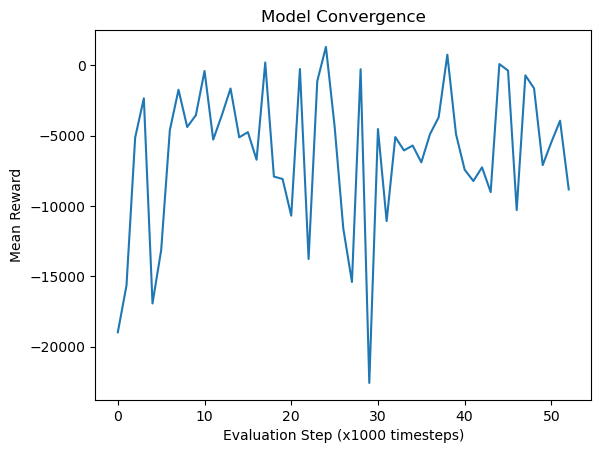

In [14]:
evaluate_model(log_path='./logs/finetune_results')

Average reward of 200 episodes is -4937.


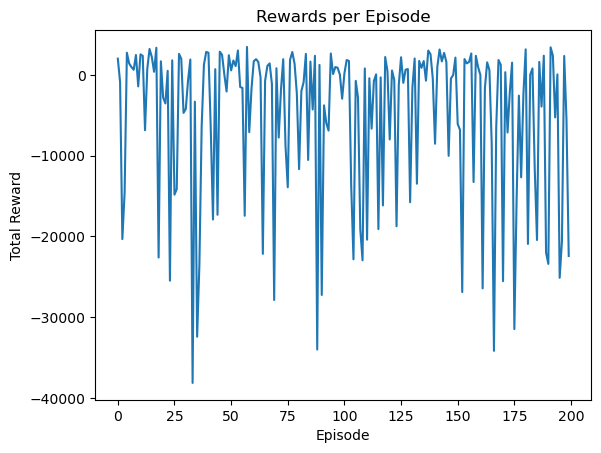

[2020,
 -890,
 -20330,
 -14540,
 2750,
 1420,
 980,
 640,
 2470,
 -1420,
 2550,
 2360,
 -6850,
 740,
 3220,
 2220,
 390,
 3370,
 -22610,
 1690,
 -2800,
 -3530,
 510,
 -25480,
 1810,
 -14830,
 -14140,
 2610,
 2000,
 -4700,
 -4200,
 -650,
 1910,
 -38140,
 -3310,
 -32420,
 -23510,
 -6400,
 1250,
 2850,
 2750,
 -6490,
 -17900,
 710,
 -17320,
 2880,
 2490,
 70,
 -2050,
 2440,
 560,
 1790,
 1100,
 3030,
 -1490,
 -1610,
 -17440,
 3470,
 -7080,
 -1680,
 1700,
 1950,
 1610,
 -310,
 -22160,
 -730,
 1120,
 1430,
 -1100,
 -27870,
 830,
 -7760,
 -1850,
 1950,
 -8760,
 -13910,
 1860,
 2840,
 1400,
 -2260,
 -11670,
 -2000,
 -890,
 2610,
 -10530,
 1650,
 -4280,
 2370,
 -34000,
 1240,
 -27250,
 -3770,
 -5960,
 -6890,
 2660,
 110,
 980,
 890,
 40,
 -2950,
 190,
 1850,
 1730,
 -13740,
 -22830,
 -730,
 -2800,
 -19090,
 -22960,
 810,
 -20400,
 -410,
 -6650,
 -740,
 70,
 -19090,
 -300,
 -16160,
 2220,
 480,
 -7990,
 550,
 -610,
 -18740,
 -1190,
 2190,
 -980,
 650,
 730,
 -15760,
 -1600,
 2040,
 -13470,
 173

In [15]:
# Model testing
model_path = './logs/ppo_finetune_model/best_model.zip'
env_test = env_gym.TrafficEnvironment()
num_episodes = 200
test_model(model_path=model_path, env=env, num_episodes=num_episodes)